### Exercise 2: Classification of Airline Tweets with RNN’s

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Attention, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings

nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Data Preprocessing: Loading the dataset and preprocessing steps as in Exercise 1.

In [2]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

tweets_df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tokens = [preprocessing(sentence) for sentence in tweets_df['text']]
tweets_df['text'] = [" ".join(token) for token in tokens]
tweets_df['text']

0                                                   said .
1         plus 've added commercial experience ... tacky .
2         n't today ... must mean need take another trip !
3        's really aggressive blast obnoxious `` entert...
4                                  's really big bad thing
                               ...                        
14635                 thank got different flight chicago .
14636    leaving 20 minute late flight. warning communi...
14637                        please bring american airline
14638    money , change flight , n't answer phone ! sug...
14639    8 ppl need 2 know many seat next flight. plz p...
Name: text, Length: 14640, dtype: object

##### Encode sentiment labels and set X as texts and numeric labels as y.

In [3]:
label_encoder = LabelEncoder()
tweets_df['label'] = label_encoder.fit_transform(tweets_df['airline_sentiment'])
X = tweets_df['text']
y = tweets_df['label']

In [36]:
# Assuming that 'text' column contains the tweet text and 'sentiment' column has the target labels (e.g., positive/negative/neutral)


# Tokenizing and padding the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, padding='post')
vocab_size = len(tokenizer.word_index) + 1
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

##### Model Training: Build RNN with Bi-LSTM, stacking multiple RNN layers and attention mechanism.

In [38]:
# Model Architecture: Stacked Bi-LSTM with Attention
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, 64, input_length=(X_train.shape[1], X_train.shape[-1])))

# Adding Bidirectional LSTM layers
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Final output layer: a single neuron with sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5952 - loss: 1.4391 - val_accuracy: 0.6453 - val_loss: 0.7407
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6193 - loss: 0.7173 - val_accuracy: 0.6406 - val_loss: 0.6868
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6251 - loss: 0.6070 - val_accuracy: 0.6364 - val_loss: 0.7012
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6207 - loss: 0.5605 - val_accuracy: 0.6405 - val_loss: 0.7389
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6217 - loss: 0.5342 - val_accuracy: 0.6415 - val_loss: 0.7388
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6238 - loss: 0.5126 - val_accuracy: 0.6360 - val_loss: 0.8139
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6253 - loss: 0.4750 - val_accuracy: 0.6415 - val_loss: 0.8244
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.6335 - loss: 0.4586 - val_acc

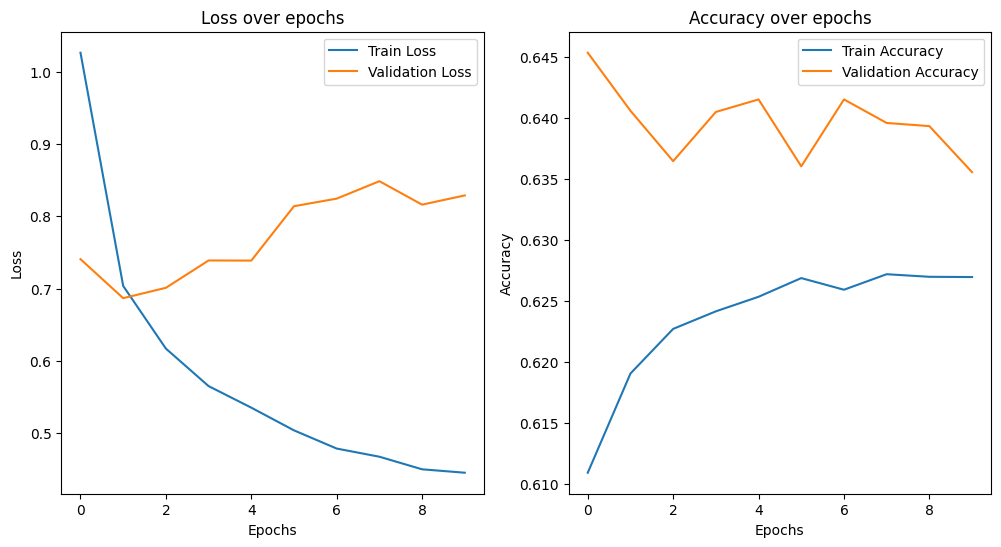

In [39]:
# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step  


ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [ ]:
#Explanation of the Model Architecture
#Model Architecture Description:

#Embedding Layer: Converts the input words into dense vector representations.
#Bidirectional LSTM: The bidirectional LSTM helps capture both past and future context in the text, improving understanding of word relationships.
###Attention Mechanism: The attention layer allows the model to focus on important words in the input sequence, improving performance in understanding long dependencies within the text.
##Global Average Pooling: This reduces the sequence to a fixed-size vector that summarizes the input sequence.
#Dense Layers: The model finishes with a dense layer for classification, using a sigmoid activation function because it is a binary classification problem.